In [103]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Reading In the Data

In [115]:
ratings = pd.read_csv("./data/ratings.csv")
links = pd.read_csv("./data/links.csv")
movies = pd.read_csv("./data/movies.csv")
tags = pd.read_csv("./data/tags.csv")

ratings.shape
ratings.head()

(100836, 4)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


We could download the IMDB dataset and do some content-based filtering based on that!

In [107]:
links.shape
links.head()

(9742, 3)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [145]:
movies.shape
movies.head()

(9742, 3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [109]:
tags.shape
tags.head()

(3683, 4)

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


Sparsity Visualizations for the User-Item Matrix
- not really necessary, but just fun to look at

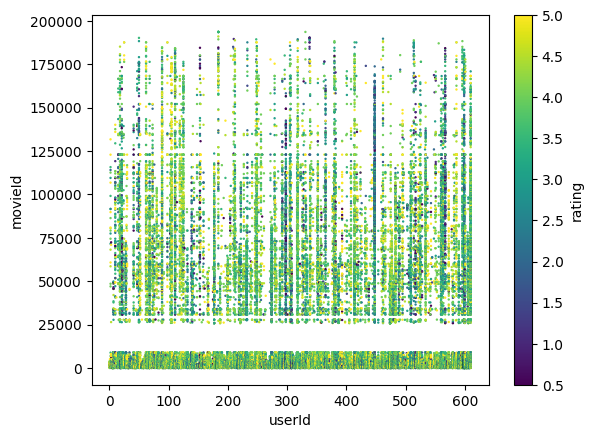

In [186]:
ratings.plot.scatter(x="userId", y="movieId",  c="rating", s = 0.5);

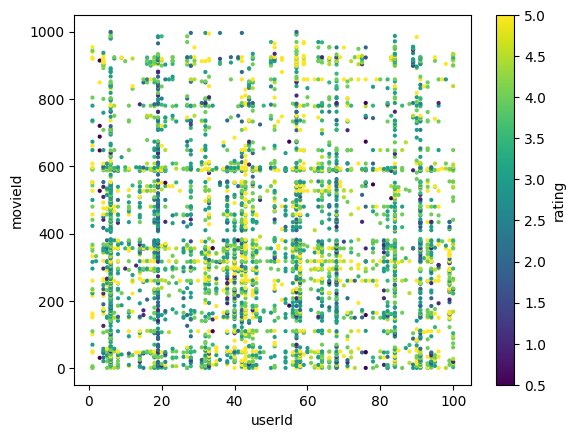

In [187]:
user_lower = 0
user_upper = 100
movie_lower = 0
movie_upper = 1000
ratings_subset = ratings.loc[ratings["userId"].between(user_lower, user_upper) & ratings["movieId"].between(movie_lower, movie_upper)]

ratings_subset.plot.scatter("userId", "movieId", s = 4, c="rating");

Interesting thing of note: there are only ~70 reviews for movies with IDs from 9000-26000
- shouldn't really matter for the model though

In [112]:
ratings.loc[ratings["movieId"].between(9000, 26000)]

,userId,movieId,rating,timestamp
13707,89,25887,5.0,1520409386
16156,104,25937,3.5,1257078081
16528,105,9010,4.5,1447537728
19325,125,9010,5.0,1474283090
25467,177,9008,2.5,1435540203
...,...,...,...,...
98304,606,25805,4.5,1171328279
98305,606,25833,4.0,1173381141
98306,606,25841,4.0,1171377632
98307,606,25850,4.5,1177442293


Exploration of distributions for movie ratings 
-ratings skewed left
-most movies rated are from 0 to 7000
-most users rate a few movies, a few users with a lot of ratings

In [131]:
ratings.rating.describe()
ratings.rating.unique()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

array([4. , 5. , 3. , 2. , 1. , 4.5, 3.5, 2.5, 0.5, 1.5])

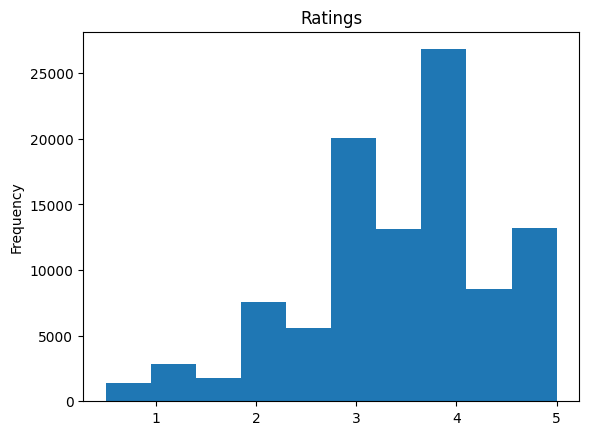

In [185]:
ratings.rating.plot.hist(title="Ratings");

<AxesSubplot:title={'center':'Movies'}, ylabel='Frequency'>

count    100836.000000
mean      19435.295718
std       35530.987199
min           1.000000
25%        1199.000000
50%        2991.000000
75%        8122.000000
max      193609.000000
Name: movieId, dtype: float64

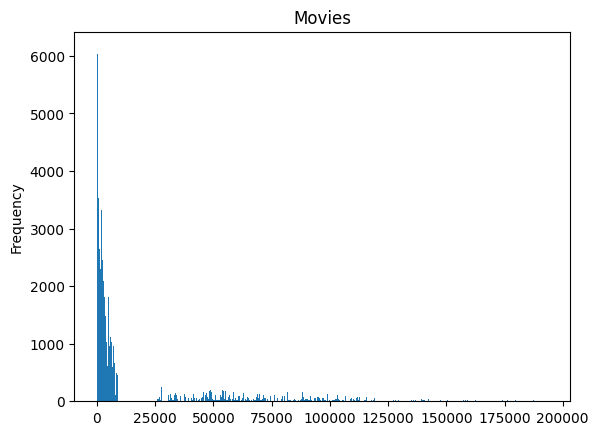

In [184]:
ratings.movieId.plot.hist(bins=1000, title="Movies");
ratings.movieId.describe()

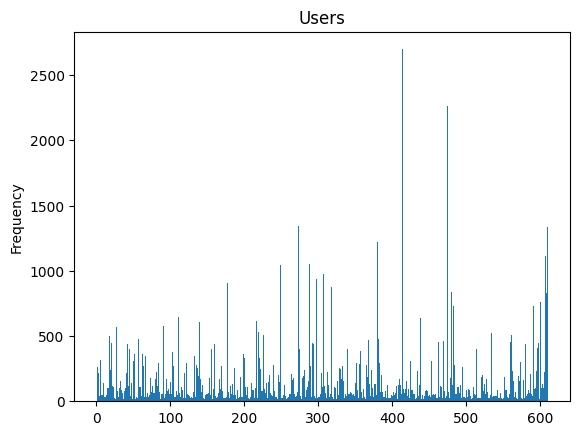

In [181]:
ratings.userId.plot.hist(bins=600, title="Users");

In [232]:
movies_rating_count = ratings.movieId.value_counts().rename_axis('movieId').to_frame('ratingCount');
movies_averageRating = ratings.groupby('movieId')['rating'].mean();
movies_data = (((movies.merge(movies_rating_count, left_on="movieId", right_on="movieId")
                        .merge(movies_averageRating, left_on="movieId", right_on="movieId"))
                       .rename(columns={"rating":"averageRating"}))
                       .set_index("movieId"));
movies_data.head()

,title,genres,ratingCount,averageRating
movieId,,,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,215,3.920930
2,Jumanji (1995),Adventure|Children|Fantasy,110,3.431818
3,Grumpier Old Men (1995),Comedy|Romance,52,3.259615
4,Waiting to Exhale (1995),Comedy|Drama|Romance,7,2.357143
5,Father of the Bride Part II (1995),Comedy,49,3.071429


Top N most commonly rated movies

In [289]:
def most_rated_movies(N : int) -> pd.DataFrame:
    return movies_data.nlargest(N, columns="ratingCount")

def highest_rated_movies(N : int) -> pd.DataFrame:
    return movies_data.nlargest(N, columns="ratingCount")

def plot_movie_rating_dist(movieId: int):
    movie_title = movies.loc[movies["movieId"] == movieId, "title"].item()
    movie_ratings = ratings.loc[ratings["movieId"] == movieId]
    movie_ratings.rating.plot.hist(subplots=True, title=movie_title)

In [290]:
top20most = most_rated_movies(20)
top20most

,title,genres,ratingCount,averageRating
movieId,,,,
356,Forrest Gump (1994),Comedy|Drama|Romance|War,329,4.164134
318,"Shawshank Redemption, The (1994)",Crime|Drama,317,4.429022
296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,307,4.197068
593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,279,4.161290
2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,278,4.192446
260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,251,4.231076
480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,238,3.750000
110,Braveheart (1995),Action|Drama|War,237,4.031646
589,Terminator 2: Judgment Day (1991),Action|Sci-Fi,224,3.970982


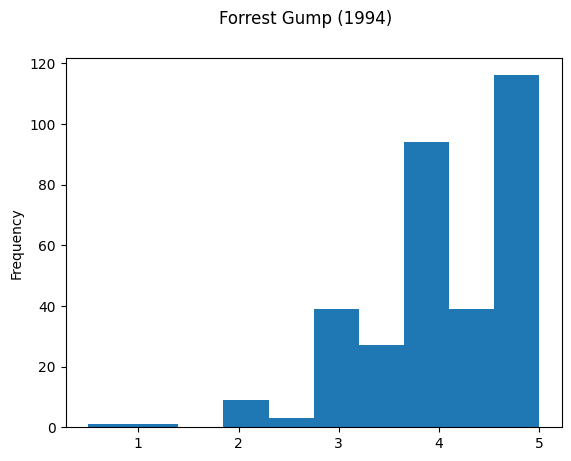

In [296]:
#haven't worked out how to generate new plots each time
plot_movie_rating_dist(356)

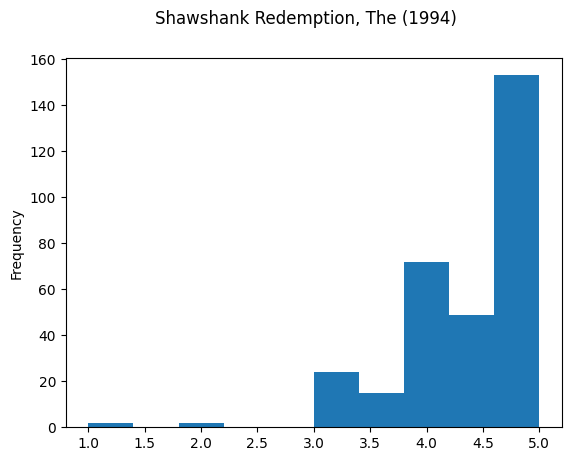

In [297]:
plot_movie_rating_dist(318)

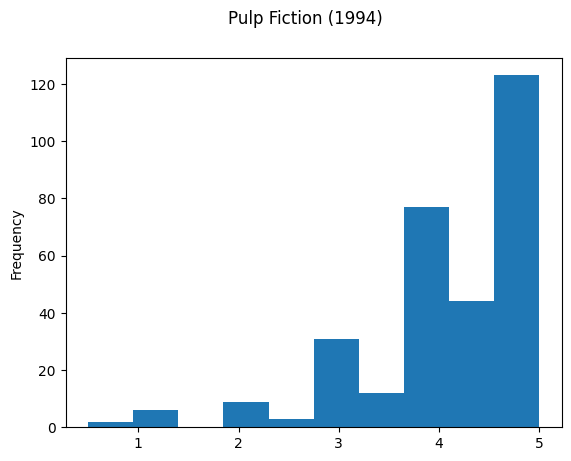

In [298]:
plot_movie_rating_dist(296)

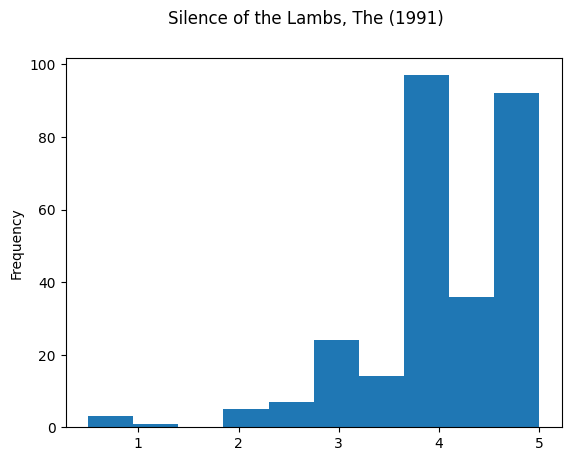

In [299]:
plot_movie_rating_dist(593)

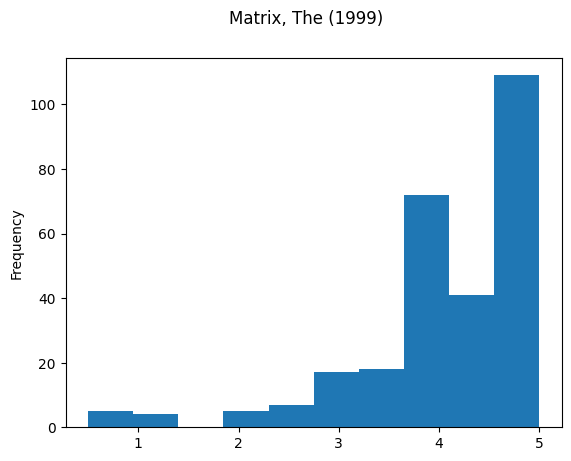

In [300]:
plot_movie_rating_dist(2571)